In [1]:
# This program computes AIC of gene expression across various distributions
# it then creates line plots that show how these AIC "winners" (those withl lowest AICs)
# in genes segmented by: fraction of samples in gene with zero reads

In [ ]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial, Gamma
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP

from scipy.stats import expon, nbinom, norm, poisson
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")


# now the DCIS count data is found in an RDA file, which we apparently read using 'pyreadr'
import pyreadr


import os

# thread issues
os.environ['OMP_NUM_THREADS'] = '10'  # Limit to 1 thread
os.environ['MKL_NUM_THREADS'] = '10'  # Limit to 1 thread for MKL (if used)
os.environ['NUMEXPR_NUM_THREADS'] = '10'  # Limit to 1 thread for NumExpr (if used)


# to convert Ensemble to Refseq gene names
gene_convert = pyreadr.read_r('/path/to/our_dcis/gene_info/ensemble_to_refseq_gene_name_table.rds')
gene_convert = gene_convert[None]
id_to_name = {gene_id: gene_name for gene_id, gene_name in zip(gene_convert["gene_id"], gene_convert["gene_name"])}


# and a function I use in the document
def variance_mean(row):
    variance = np.var(row, ddof=1) # “Delta Degrees of Freedom”
    mean = np.mean(row)
    std_dev = np.sqrt(variance) # sometimes this is considered dispersion
    
    # I'm a bit confused exactly how I'd compute a dataset-wide dispersion from this data
    # the formula given is Variance = mean + dispersion*mean^2
    # re-arranged, this gives dispersion = (variance - mean)/(mean*mean)
    # I guess we can try it
    dispersion = 0 # in case the mean is zero, or if variance = mean
    if ((mean != 0) & (variance != mean)):
        #dispersion = (variance - mean)/(mean**2)
        dispersion = (mean**2)/(variance - mean) # did I have this backwards?
        inverse_dispersion = dispersion**-1
    
    # and they define "expected fraction zeros" as exp(-mean) - Poisson distribution!
    #prob_frac = math.exp(mean*-1)
    
    # lets do the NB formulation
    prob_frac = 1 # if dispersion is zero, the fraction zero is 100%
    if (dispersion >0):
        prob_frac = ((inverse_dispersion)/(mean + inverse_dispersion))**(inverse_dispersion)
    
    # we will also want to know the fraction of the row that equals zero
    zero_frac = (row == 0).sum()/len(row)
    return pd.Series({'variance': variance, 'mean': mean, "StDev": std_dev, "Dispersion": dispersion, 'zero_fraction': zero_frac, 'prob_frac': prob_frac})

In [3]:
### Parameters ###

# whether or not we're doing outlier removal using trimmed means
trim_means_flag = True
trim_percent = 10 # 1% usually gets rid of most extreme outliers

# genes must be expressed in this % of patients (between 0-1)
express_percent_limit = 0.0 # needs to be zero in this program

# library adjust (using fractional method)
adjust_for_lib = False

# calculate AIC distance
calc_AIC_dist = False # False saves time when running the full program

# a flag if we want to just do "no ZI" or "NB vs ZINB only"
NB_ZINB_only = False # Only comparing NB to ZINB [trim_percent should be low, maybe even zero]

# trim will remove zeroes, so I don't think we should activate trim when doing NB/ZINB comparison
if (NB_ZINB_only == True):
    trim_percent = 0

no_ZI_AICs = False

In [4]:
# non-AIC related functions used in this program    

# computation of gene average, fraction of zeroes, and library size
def dataset_stats_generator(df, draw_zero_distribution = True):
    num_genes = df.shape[0]
    num_samples = df.shape[1]
    # Compute the metrics for each row
    row_sums = df.sum(axis = 0)
    fraction_zero_samples = (df == 0).sum(axis=0) / num_genes
    fraction_zero_genes = (df == 0).sum(axis=1) / num_samples
    row_means = df.mean(axis=1)

    if (draw_zero_distribution):
        plt.hist(fraction_zero_genes, bins=100, color='blue', alpha=0.7)
        plt.xlabel('Fraction of Zeroes (Genes)')
        plt.ylabel('Count')
        plt.title("Fraction of Zeroes per Gene")
        plt.show()

        plt.hist(fraction_zero_samples, bins=100, color='blue', alpha=0.7)
        plt.xlabel('Fraction of Zeroes (Samples)')
        plt.ylabel('Count')
        plt.title("Fraction of Zeroes per Sample")
        plt.show()

        plt.hist(row_means, bins=100, color='blue', alpha=0.7)
        plt.xlabel('Means of Gene Expression')
        plt.ylabel('Count')
        plt.title("Distribution of Means of Genes in Dataset")
        plt.show()
      
    # get the average of these 
    avg_library_size = np.round(np.sum(row_sums) / num_samples, decimals = 0)
    avg_zeroes = np.round(np.sum(fraction_zero_samples) / num_samples, decimals = 3)
    avg_mean_expression = np.round(np.mean(row_means), decimals = 3)
    
    # print("Avg Library Size", "Avg Fraction Zeroes", "Avg Mean Expression")
    return avg_library_size, avg_zeroes, avg_mean_expression

# Simulating some data for illustration
#data = np.random.negative_binomial(10, 0.5, 1000)

def fit_to_nb_plot(data, plotrange = 30):

    # Estimating parameters directly from data
    mean = np.mean(data)
    var = np.var(data)
    p = 1 - (mean / var)
    n = mean * (1 - p) / p

    # Plotting
    plt.hist(data, bins=range(plotrange), align='left', density=True, alpha=0.6, color='g')
    plt.plot(bins[:-1], nbinom.pmf(bins[:-1], n, p), 'ro-', lw=2)
    plt.title("Negative Binomial Fit")
    plt.show()

# adjust for library sizes
def library_adjust(data):
    if (adjust_for_lib):
        library_size = data.sum(axis=0)
        
        cleaned_matrix = np.round((data /library_size)*10000000)
        return cleaned_matrix
    else:
        return data

In [5]:
# ZINB

def zinb_loglike(params, counts):
    mu, theta, pi = params
    p = 1 / (1 + mu/theta)
    n = mu * p / (1 - p)
    loglik_pois = nbinom.logpmf(counts, n, p)
    loglik_zero = np.log(pi + (1 - pi) * np.exp(nbinom.logpmf(0, n, p)))
    loglik = np.where(counts == 0, loglik_zero, np.log(1 - pi) + loglik_pois)
    return -np.sum(loglik)

def calculate_aic(loglik, k):
    return 2*k - 2*loglik

def fit_zinb_and_calculate_aic(counts):
    
    initial_params = np.array([np.mean(counts), np.var(counts), 0.5])
    bounds = [(0, None), (0, None), (0, 1)]
    result = minimize(zinb_loglike, initial_params, args=(counts), bounds=bounds)
    mu, theta, pi = result.x
    loglik = -result.fun
    
    k = 3  # Number of parameters
    aic = calculate_aic(loglik, k)
    return mu, theta, pi, aic

In [6]:
# functions to compute ZIP
def zip_loglike(params, counts):
    mu, pi = params
    loglik_pois = poisson.logpmf(counts, mu)
    loglik_zero = np.log(pi + (1 - pi) * np.exp(poisson.logpmf(0, mu)))
    loglik = np.where(counts == 0, loglik_zero, np.log(1 - pi) + loglik_pois)
    return -np.sum(loglik)

def calculate_aic(loglik, k):
    return 2*k - 2*loglik

def fit_zip_and_calculate_aic(counts):
    
    initial_params = np.array([np.mean(counts), 0.5])
    bounds = [(0, None), (0, 1)]
    result = minimize(zip_loglike, initial_params, args=(counts), bounds=bounds)
    mu, pi = result.x
    loglik = -result.fun
    k = 2  # Number of parameters for ZIP model
    aic = calculate_aic(loglik, k)
    return mu, pi, aic

In [7]:
def compare_distributions(aic_values):
    distribution_types = {
        "NB": aic_values["NB"],
        "Gaussian": aic_values["Gaussian"],
        "Poisson": aic_values["Poisson"],
        "Exponential": aic_values["Exponential"],
        "ZIP": aic_values["Zero-Inflated Poisson"],
        "ZINB": aic_values["Zero-Inflated Negative Binomial"]
    }

    min_aic_type = min(distribution_types, key=distribution_types.get)
    min_aic_value = distribution_types[min_aic_type]

    return min_aic_type, min_aic_value



# this is the function that computes AIC for all distributions (Gaussian, Exponential, Negative Binomial, ZIP, ZINB)
# and reports which distribution is lowest
# row - a vector of expressions
def manual_aic(row):
    
    row = np.round(row) # it must be count data

    # trimmed mean to remove outliers
    n = len(row)
    
    if (trim_means_flag):
        elements_to_trim = int(np.floor(trim_percent / 100.0 * n))  
        sorted_data = np.sort(row)
        
        if (elements_to_trim > 0):
            row = sorted_data[elements_to_trim:-elements_to_trim]
        else: 
            row = sorted_data

    if (sum(row) <= 0):
        return "ZEROES"

    X = sm.add_constant(np.ones(len(row)))

    # Exponential parameters
    lambda_exp = 1 / np.mean(row)
    log_likelihood_exp = np.sum(expon.logpdf(row, scale=1/lambda_exp))
    aic_exp = 2*1 - 2*log_likelihood_exp  # 1 parameter for exponential

    # log -> linear -> delog
    # using StatsModels to fit to a Gamma (it doesn't have exponential)
    #model_exponential_approx = sm.GLM(row, X, family=Gamma()).fit()
    #print('AIC for Gamma:', model_exponential_approx.aic)
    #aic_exp = model_exponential_approx.aic

    # Compute AIC to NB manually 
    mu_sample = np.mean(row)
    var_sample = np.var(row)
    if (mu_sample == var_sample):
        var_sample = var_sample + 0.0000000000001
    r_estimated = mu_sample**2 / (var_sample - mu_sample)
    
    if (mu_sample + r_estimated) == 0:
        r_estimated = r_estimated + 0.0000000000001
    p_estimated = r_estimated / (mu_sample + r_estimated)
    #log_likelihood_nb = np.sum(nbinom.logpmf(row, r_estimated, p_estimated))
    #aic_nb = 2*2 - 2*log_likelihood_nb  # 2 parameters for NB

    res = sm.NegativeBinomial(row, X).fit(start_params=[1,1], disp=0)
    
    const = res.params[0]
    alpha = res.params[1]

    mu = np.exp(const)
    p = 1/(1+np.exp(const)*alpha)
    n = np.exp(const)*p/(1-p)

    nb_theta = mu * (1 - p) / p

    aic_nb = res.aic

    # ZINB parameters
    mu, zinb_theta, zinb_pi, aic = fit_zinb_and_calculate_aic(row)
    aic_zinb = aic
    
    # AIC of Gaussian following IRLS (IRLS)
    model_gaussian = sm.GLM(row, X, family=sm.families.Gaussian()).fit(disp=0)
    aic_gauss = model_gaussian.aic


    # Poisson parameters (all methods give the same AIC)
    model_poisson = sm.Poisson(row, X).fit(disp=0)
    aic_pois = model_poisson.aic

    # ZIP
    mu, pi, aic = fit_zip_and_calculate_aic(row)
    aic_zip = aic
    #print(f"mu: {mu}, pi: {pi}, AIC: {aic}")


    # sometimes ZIP and ZINB can be NaN if there are no zeroes
    # NB can also become NaN if Mean > Variance (I think)
    # just in case, lets add this check for all of them
    aic_scores = {'aic_zip': aic_zip, 'aic_zinb': aic_zinb, 'aic_nb': aic_nb, 'aic_pois': aic_pois, 'aic_gauss': aic_gauss, 'aic_exp': aic_exp}

    for key in aic_scores:
        if np.isnan(aic_scores[key]) | np.isinf(aic_scores[key]):
            aic_scores[key] = 100000000

    aic_zip, aic_zinb, aic_nb, aic_pois, aic_gauss, aic_exp = aic_scores.values()
        
    # in certain analyses, we might only want to look at certain distributions
    # so we will make the AIC score high for those we don't care about
    if (NB_ZINB_only == True):
        aic_zip, aic_pois, aic_gauss, aic_exp = 10000000, 10000000, 10000000, 10000000
    if (no_ZI_AICs == True):
        aic_zip, aic_zinb = 10000000, 10000000
    
    # print(aic_nb, aic_gauss, aic_pois, aic_exp)
    best_distribution, best_aic = compare_distributions({
        "NB": aic_nb,
        "Gaussian": aic_gauss,
        "Poisson": aic_pois,
        "Exponential": aic_exp,
        "Zero-Inflated Poisson": aic_zip,
        "Zero-Inflated Negative Binomial": aic_zinb
    })

    return best_distribution #, nb_theta, zinb_theta, zinb_pi


In [8]:
# ORIGINAL AIC CALCULATION PROGRAM
"""
import numpy as np
from scipy.stats import expon, nbinom, norm, poisson

# lets turn this into a function
def manual_aic(row):
    
    row = np.round(row) # make it count data
    
    # what if we adjust the row with elimination of outliers
    # IQR is distribution agnostic which is why I chose it
    Q1 = np.percentile(row, 25)
    Q3 = np.percentile(row, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    # row = row[(row >= lower_bound) & (row <= upper_bound)]
    
    if (sum(row) <= 0):
        return "ZEROES"

    # Exponential parameters
    lambda_exp = 1 / np.mean(row)
    log_likelihood_exp = np.sum(expon.logpdf(row, scale=1/lambda_exp))
    aic_exp = 2*1 - 2*log_likelihood_exp  # 1 parameter for exponential

    # NB parameters
    mu_sample = np.mean(row)
    var_sample = np.var(row)
    if (mu_sample == var_sample):
        var_sample = var_sample + 0.0000000000001
    r_estimated = mu_sample**2 / (var_sample - mu_sample)
    
    if (mu_sample + r_estimated) == 0:
        r_estimated = r_estimated + 0.0000000000001
    p_estimated = r_estimated / (mu_sample + r_estimated)
    log_likelihood_nb = np.sum(nbinom.logpmf(row, r_estimated, p_estimated))
    aic_nb = 2*2 - 2*log_likelihood_nb  # 2 parameters for NB

    # ZINB parameters
    pi_zinb = np.mean(row == 0)
    log_likelihood_zeros = np.sum(np.log(pi_zinb) * (row == 0))
    log_likelihood_non_zeros = np.sum(np.log(1 - pi_zinb) + nbinom.logpmf(row[row != 0], r_estimated, p_estimated))
    log_likelihood_zinb = log_likelihood_zeros + log_likelihood_non_zeros
    aic_zinb = 2*3 - 2*log_likelihood_zinb  # 3 parameters for ZINB: pi, r, and p

    # Gaussian parameters
    mu_gauss = np.mean(row)
    sigma_gauss = np.std(row)
    log_likelihood_gauss = np.sum(norm.logpdf(row, mu_gauss, sigma_gauss))
    aic_gauss = 2*2 - 2*log_likelihood_gauss  # 2 parameters for Gaussian: mu and sigma

    # Poisson parameters
    lambda_pois = np.mean(row)
    log_likelihood_pois = np.sum(poisson.logpmf(row, lambda_pois))
    aic_pois = 2*1 - 2*log_likelihood_pois  # 1 parameter for Poisson: lambda

    # ZIP parameters
    pi_zip = np.mean(row == 0)
    lambda_zip = np.mean(row[row != 0])
    log_likelihood_zeros_zip = np.sum(np.log(pi_zip) * (row == 0))
    log_likelihood_non_zeros_zip = np.sum(np.log(1 - pi_zip) + poisson.logpmf(row[row != 0], lambda_zip))
    log_likelihood_zip = log_likelihood_zeros_zip + log_likelihood_non_zeros_zip
    aic_zip = 2*2 - 2*log_likelihood_zip  # 2 parameters for ZIP: pi and lambda

    # sometimes ZIP and ZINB can be NaN if there are no zeroes
    # NB can also become NaN if Mean > Variance (I think)
    # just in case, lets add this check for all of them
    if np.isnan(aic_zip):
        aic_zip = 1000000000000
    if np.isnan(aic_zinb):
        aic_zinb = 1000000000000
    if np.isnan(aic_nb):
        aic_nb = 1000000000000
    if np.isnan(aic_pois):
        aic_pois = 1000000000000
    if np.isnan(aic_gauss):
        aic_gauss = 1000000000000
    if np.isnan(aic_exp):
        aic_exp = 1000000000000
        
   
    # Compare AICs and determine best fit
    if (aic_nb < aic_pois ) & (aic_nb < aic_gauss) & (aic_nb < aic_exp) & (aic_nb < aic_zip) & (aic_nb < aic_zinb):
        return "NB"
    elif (aic_gauss < aic_nb) & (aic_gauss < aic_pois) & (aic_gauss < aic_exp) & (aic_gauss < aic_zip) & (aic_gauss < aic_zinb):
        return "Gaussian"
    elif (aic_exp < aic_nb) & (aic_exp < aic_pois) & (aic_exp < aic_gauss) & (aic_exp < aic_zip) & (aic_exp < aic_zinb):
        return "Exponential"
    elif (aic_zinb < aic_nb) & (aic_zinb < aic_pois) & (aic_zinb < aic_gauss) & (aic_zinb < aic_zip) & (aic_zinb < aic_exp):
        return "ZINB"
    elif (aic_zip < aic_nb) & (aic_zip < aic_pois) & (aic_zip < aic_gauss) & (aic_zip < aic_zinb) & (aic_zip < aic_exp):
        return "ZIP"
    else:
        return "Poisson"

"""

'\nimport numpy as np\nfrom scipy.stats import expon, nbinom, norm, poisson\n\n# lets turn this into a function\ndef manual_aic(row):\n    \n    row = np.round(row) # make it count data\n    \n    # what if we adjust the row with elimination of outliers\n    # IQR is distribution agnostic which is why I chose it\n    Q1 = np.percentile(row, 25)\n    Q3 = np.percentile(row, 75)\n    IQR = Q3 - Q1\n\n    lower_bound = Q1 - 2 * IQR\n    upper_bound = Q3 + 2 * IQR\n    # row = row[(row >= lower_bound) & (row <= upper_bound)]\n    \n    if (sum(row) <= 0):\n        return "ZEROES"\n\n    # Exponential parameters\n    lambda_exp = 1 / np.mean(row)\n    log_likelihood_exp = np.sum(expon.logpdf(row, scale=1/lambda_exp))\n    aic_exp = 2*1 - 2*log_likelihood_exp  # 1 parameter for exponential\n\n    # NB parameters\n    mu_sample = np.mean(row)\n    var_sample = np.var(row)\n    if (mu_sample == var_sample):\n        var_sample = var_sample + 0.0000000000001\n    r_estimated = mu_sample**2 / (v

In [9]:
def segmental_aic_find(counts):
    add_vector_nb, add_vector_exp, add_vector_zinb, sample_total = [], [], [], []
    add_vector_zip, add_vector_gaussian, add_vector_poisson = [], [], []
    wf_nb, wf_zinb, wf_gau, wf_poi, wf_zip, wf_exp = 1,1,1,1,1,1

    for i in range(0,6):
        less_than_value = i*2/10
        greater_than_value = (i-1)*2/10
    
        fraction_of_zeroes = (counts == 0).mean(axis=1)
        filtered_df = counts[(fraction_of_zeroes <= less_than_value) & (fraction_of_zeroes > greater_than_value)] # lets match

        sample_total.append(filtered_df.shape[0])
    
        aic_values = filtered_df.apply(manual_aic, axis=1)
        ratio_NB_to_Gaussian = aic_values.value_counts()
        

        # to add zero if the distribution didn't occur
        if(wf_nb == 0):
           add_vector_nb.append(0)
        if(wf_zinb == 0):
            add_vector_zinb.append(0)
        if(wf_zip == 0):
            add_vector_zip.append(0)        
        if(wf_poi == 0):
            add_vector_poisson.append(0)
        if(wf_gau == 0):
            add_vector_gaussian.append(0)
        if(wf_exp == 0):
            add_vector_exp.append(0)
    
        wf_nb, wf_zinb, wf_gau, wf_poi, wf_zip, wf_exp = 0,0,0,0,0,0
    
        names = ratio_NB_to_Gaussian.index
        values = ratio_NB_to_Gaussian.values
    
        # add to individual vectors
        for i in range(len(names)):
            if(names[i] == 'NB'):
                add_vector_nb.append(values[i])
                wf_nb = 1
            if(names[i] == 'ZINB'):
                add_vector_zinb.append(values[i])
                wf_zinb = 1
            if(names[i] == 'ZIP'):
                add_vector_zip.append(values[i])
                wf_zip = 1
            if(names[i] == 'Poisson'):
                add_vector_poisson.append(values[i])
                wf_poi = 1
            if(names[i] == 'Gaussian'):
                add_vector_gaussian.append(values[i])
                wf_gau = 1
            if(names[i] == 'Exponential'):
                add_vector_exp.append(values[i])
                wf_exp = 1
        
    # need to do it once again for the last value
    if(wf_nb == 0):
        add_vector_nb.append(0)
    if(wf_zinb == 0):
        add_vector_zinb.append(0)
    if(wf_zip == 0):
        add_vector_zip.append(0)        
    if(wf_poi == 0):
        add_vector_poisson.append(0)
    if(wf_gau == 0):
        add_vector_gaussian.append(0)
    if(wf_exp == 0):
        add_vector_exp.append(0)
    
    return add_vector_nb, add_vector_zinb, add_vector_zip, add_vector_poisson, add_vector_gaussian, add_vector_exp, sample_total
    

In [ ]:
# don't forget we want to take the average value

import matplotlib.pyplot as plt

# Create a vector of x-values (input values)
def gradual_aic_plot(data, title_add=""):
    x_values = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
    # order is: add_vector_nb, add_vector_zinb, add_vector_zip, add_vector_poisson,
    # add_vector_gaussian, add_vector_exp, sample_total
    add_vector_nb = data[0]
    add_vector_zinb = data[1]
    add_vector_zip = data[2]
    add_vector_poisson = data[3]
    add_vector_gaussian = data[4]
    add_vector_exp = data[5]
    sample_total = data[6]
    
    fraction_nb = [x / y for x, y in zip(add_vector_nb, sample_total)]
    fraction_zinb = [x / y for x, y in zip(add_vector_zinb, sample_total)]
    fraction_exp = [x / y for x, y in zip(add_vector_exp, sample_total)]
    fraction_zip = [x / y for x, y in zip(add_vector_zip, sample_total)]
    fraction_gau = [x / y for x, y in zip(add_vector_gaussian, sample_total)]
    fraction_poi = [x / y for x, y in zip(add_vector_poisson, sample_total)]

    # Create a line plot
    plt.plot(x_values, fraction_nb, marker='o', linestyle='-', label='NB')
    plt.plot(x_values, fraction_zinb, marker='o', linestyle='-', label='ZINB')
    plt.plot(x_values, fraction_exp, marker='o', linestyle='-', label='Exponential')
    #plt.plot(x_values, fraction_poi, marker='o', linestyle='-', label='Poisson')
    #plt.plot(x_values, fraction_zip, marker='o', linestyle='-', label='ZIP')
    plt.plot(x_values, fraction_gau, marker='o', linestyle='-', label='Gaussian')

    # Add labels and a title
    plt.xlabel('Fraction of Zeroes')
    plt.ylabel('% of Genes Best Fitting This Distribution')
    
    title_text = f"Proportional Distribution of Genes with Lowest AIC [{title_add}]"
    
    plt.title(title_text)
    plt.legend()
    # save the plot
    plt.savefig('/path/to/6.1_Third_Party_Data.Best_AIC_vs_ZeroFraction_Plot_Generator/Proportional_Distribution_AIC.' +
                str(title_add) + ".ZeroFract_" + str(express_percent_limit) + ".Trim_" + str(trim_percent) + ".pdf",
             dpi=300, bbox_inches='tight')  # dpi is dots per inch, for resolution

    # Show the plot
    plt.show()

GSE167977 - Lowest AIC across all genes


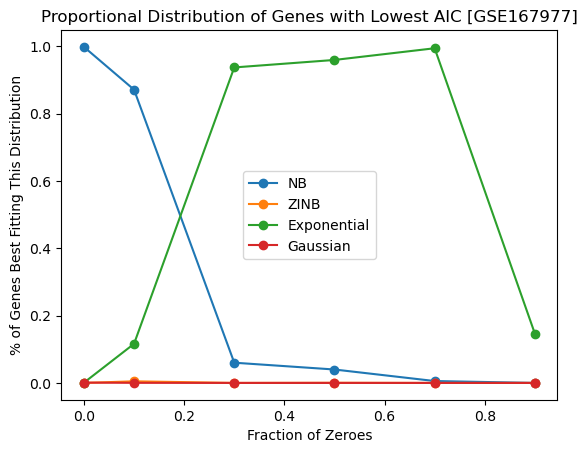

In [ ]:
# this is a dataset with 528 FFPE breast cancer samples, sequenced from a HiSeq

data = pd.read_csv('/path/to/third_party/GSE167977_third_party_ffpe/GSE167977_Raw_Counts.txt',
                  delimiter='\t')

# filter and compute dispersion
# dispersion of tumours - All Data
tumours_counts = pd.DataFrame(data)
tumours_counts = tumours_counts.drop(tumours_counts.columns[0], axis=1) # column 1
tumours_counts = tumours_counts.drop(tumours_counts.columns[-5:], axis=1) # last 5 columns

# adjust for library size (fraction method)
# should come before the gene filter
tumours_counts_lib_adjust = library_adjust(tumours_counts)

fraction_of_zeroes = (tumours_counts_lib_adjust == 0).mean(axis=1)
filtered_df = tumours_counts_lib_adjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

print("GSE167977 - Lowest AIC across all genes")

data = segmental_aic_find(tumours_counts)
gradual_aic_plot(data, "GSE167977")

GSE181466


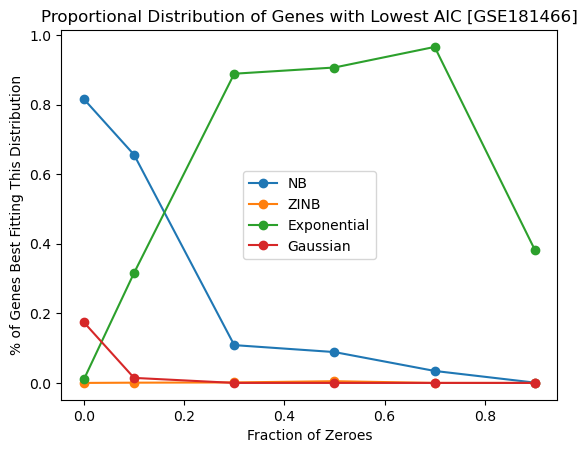

In [ ]:
data = pd.read_csv('/path/to/third_party/GSE181466_third_party_ffpe/GSE181466_rsem_genes_matrix-97.txt',
                  delimiter='\t')

# patient information splitting is unnecessary, this appears to all be both FFPE and from tumours
# there is subtype and age information in the series matrix file, if we're interested

# dispersion of tumours - All Data
tumours_counts = pd.DataFrame(data)
# removing gene column at position 0
tumours_counts = tumours_counts.drop(tumours_counts.columns[0], axis=1)
# skip genes that are all zeroes, or just one spurrious read somewhere

# adjust for library size (fraction method)
tumours_counts_libadjust = library_adjust(tumours_counts)

fraction_of_zeroes = (tumours_counts_libadjust == 0).mean(axis=1)
filtered_df = tumours_counts_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

print("GSE181466")
data = segmental_aic_find(tumours_counts)
gradual_aic_plot(data, "GSE181466") 


GSE146889 - Tumours


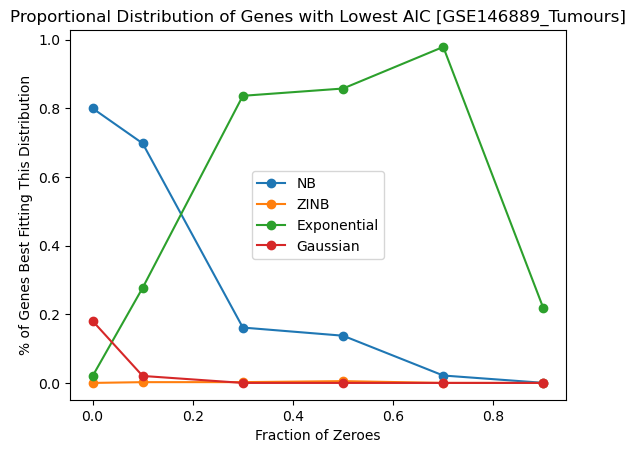

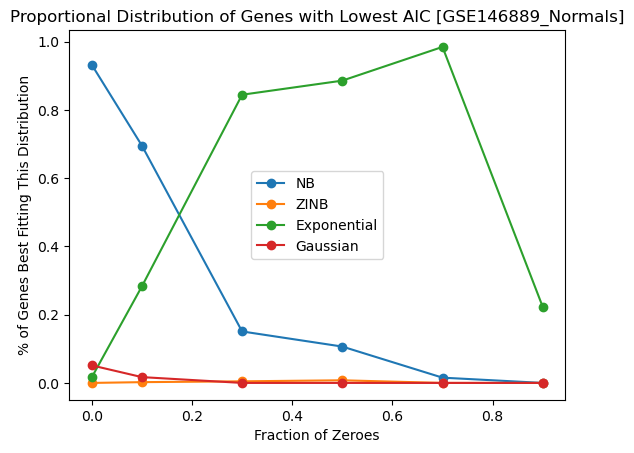

In [ ]:
## here, we will repeat our plots but for a different data set
all_counts = pyreadr.read_r('/path/to/third_party/GSE146889_third_party_ffpe/GSE146889_GeneCount.rds')
df = all_counts[None] # load all_counts into a pandas data frame

# we need to split the tumors and normals by name
count_TUMOR = df.filter(like='tumor')
count_NORMAL = df.filter(like='normal')

count_TUMOR_libadjust = library_adjust(count_TUMOR)
fraction_of_zeroes = (count_TUMOR_libadjust == 0).mean(axis=1)
filtered_tumour = count_TUMOR_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

# adjust for library size (fraction method)
count_NORMAL_libadjust = library_adjust(count_NORMAL)
fraction_of_zeroes = (count_NORMAL_libadjust == 0).mean(axis=1)
filtered_normal = count_NORMAL_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


print("GSE146889 - Tumours")
tum_data = segmental_aic_find(filtered_tumour)
gradual_aic_plot(tum_data, "GSE146889_Tumours") 

norm_data = segmental_aic_find(filtered_normal)
gradual_aic_plot(norm_data, "GSE146889_Normals") 

GSE209998


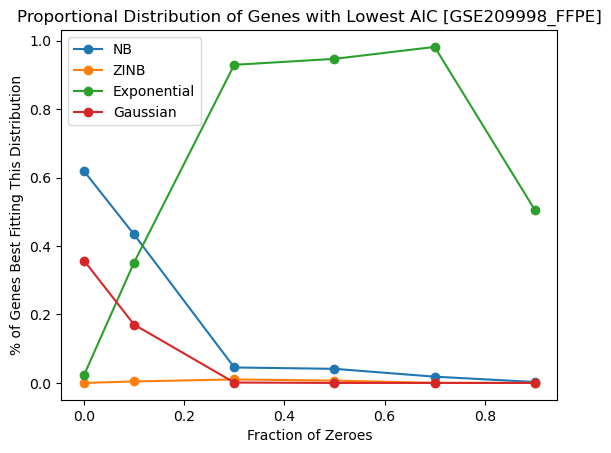

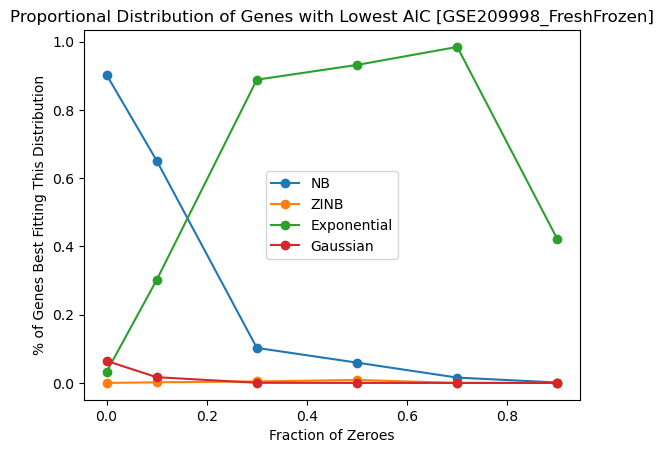

In [ ]:
all_counts = pyreadr.read_r('/path/to/third_party/GSE209998_third_party_ffpe/GSE209998_GeneCount.rds')
sample_information = pyreadr.read_r('/path/to/third_party/GSE209998_third_party_ffpe/GSE209998_Sample_Data.rds')

# now we want to isolate just the expression from a particular type of tissue
df_counts = all_counts[None] # load all_counts into a pandas data frame
df_sample = sample_information[None] # load all_counts into a pandas data frame

# here, we need to match if a sample is normal or tumour by !Sample_source_name_ch1 row

# so I need to: 1) match columns between sample_information and all_counts 
# are they in the same order
columns_df1 = df_counts.columns
columns_df2 = df_sample.columns

# Now we find what samples were tumours and what were normal
samples_row = df_sample.loc["!Sample_source_name_ch1"]

split_dfs = {}
for sample_type in samples_row.unique():
    matching_columns = [col for col in df_counts.columns if col in df_sample.columns and samples_row[col] == sample_type]
    split_dfs[sample_type] = df_counts[matching_columns]

sample_source = df_sample.loc["!Sample_source"]

split_source = {}
for sample_type in sample_source.unique():
    matching_columns = [col for col in df_counts.columns if col in df_sample.columns and sample_source[col] == sample_type]
    split_source[sample_type] = df_counts[matching_columns]


count_FRESH = split_source["Fresh frozen"]
count_FFPE = split_source["FFPE"]

count_FFPE_libadjust = library_adjust(count_FFPE)
fraction_of_zeroes = (count_FFPE_libadjust == 0).mean(axis=1)
filtered_ffpe = np.round(count_FFPE_libadjust[fraction_of_zeroes < (1 - express_percent_limit)]) # must be expressed to this percentage of patients

count_FRESH_libadjust = library_adjust(count_FRESH)
fraction_of_zeroes = (count_FRESH_libadjust == 0).mean(axis=1)
filtered_fresh = np.round(count_FRESH_libadjust[fraction_of_zeroes < (1 - express_percent_limit)]) # must be expressed to this percentage of patients



print("GSE209998")

ffpe_data = segmental_aic_find(filtered_ffpe)
gradual_aic_plot(ffpe_data, "GSE209998_FFPE") 

fresh_data = segmental_aic_find(filtered_fresh)
gradual_aic_plot(fresh_data, "GSE209998_FreshFrozen") 



GSE47462


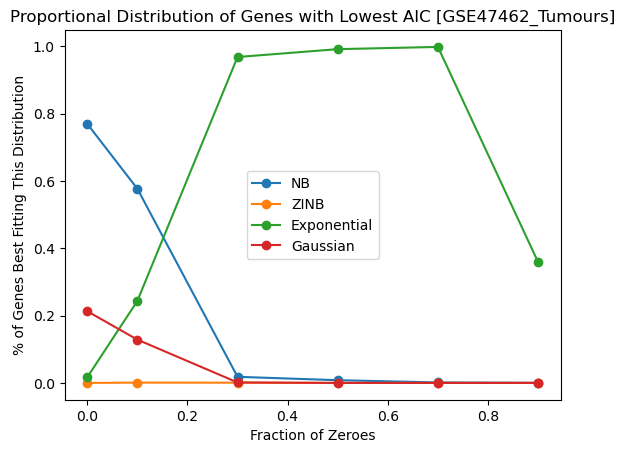

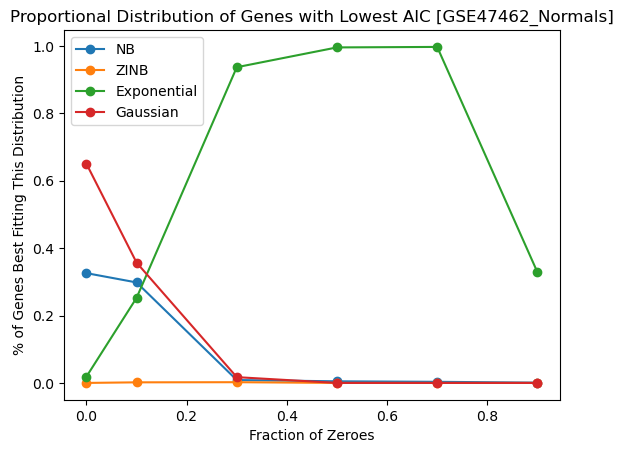

In [ ]:
data = pd.read_csv('/path/to/third_party/GSE47462_third_party_ffpe/GSE47462_Raw_counts_Refseq_genes.txt',
                  delimiter='\t')

# Split the DataFrame into subsets based on column names indicating sample type
normal_data = data.filter(like='_normal')
EN_data = data.filter(like='_EN')
DCIS_data = data.filter(like='_DCIS')
IDC_data = data.filter(like='_IDC')

# since there isn't a ton of data, I also want to group tumors
tumours_data = data.loc[:, ~data.columns.str.contains('_normal')]
tumours_data = tumours_data.iloc[:, 1:]

tumours_data_libadjust = library_adjust(tumours_data)
fraction_of_zeroes = (tumours_data_libadjust == 0).mean(axis=1)
filtered_tumour = tumours_data_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

normal_data_libadjust = library_adjust(normal_data)
fraction_of_zeroes = (normal_data_libadjust == 0).mean(axis=1)
filtered_normal = normal_data_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


print("GSE47462")
tum_data = segmental_aic_find(filtered_tumour)
gradual_aic_plot(tum_data, "GSE47462_Tumours") 

norm_data = segmental_aic_find(filtered_normal)
gradual_aic_plot(norm_data, "GSE47462_Normals") 


GSE120795


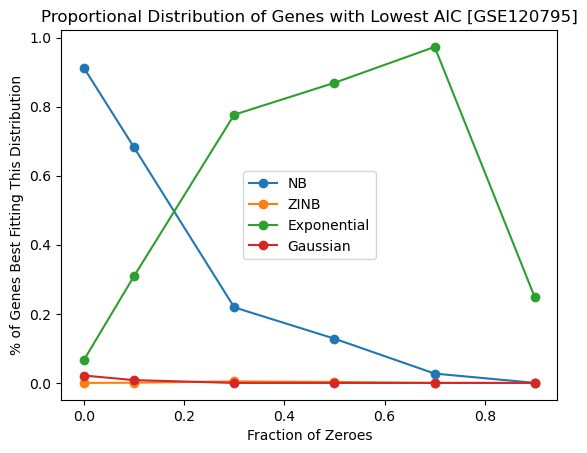

In [ ]:
# Read the CSV file into a DataFrame
data = pd.read_csv('/path/to/third_party/GSE120795_third_party_ffpe/GSE120795_total_norms_raw_counts.tsv',
                  delimiter='\t')

# in the series matrix"disease: healthy", 
patient_info = pd.read_csv('/path/to/third_party/GSE120795_third_party_ffpe/GSE120795_cell_info.txt',
                  delimiter='\t')

mask = patient_info.iloc[0] == "healthy"

filtered_data = patient_info.loc[:, mask]
patient_names = filtered_data.columns
column_names_with_extension = [name + ".fastq.gz" for name in patient_names]
column_names_with_extension = column_names_with_extension[1:]

# Assuming 'second_list' is the list where you want to filter based on column names
filtered_data = data[column_names_with_extension]
ffpe_counts = pd.DataFrame(filtered_data)


ffpe_counts_libadjust = library_adjust(ffpe_counts)
fraction_of_zeroes = (ffpe_counts_libadjust == 0).mean(axis=1)
filtered_data = ffpe_counts_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


print("GSE120795")
tum_data = segmental_aic_find(filtered_data)
gradual_aic_plot(tum_data, "GSE120795") 


TMBC_Project


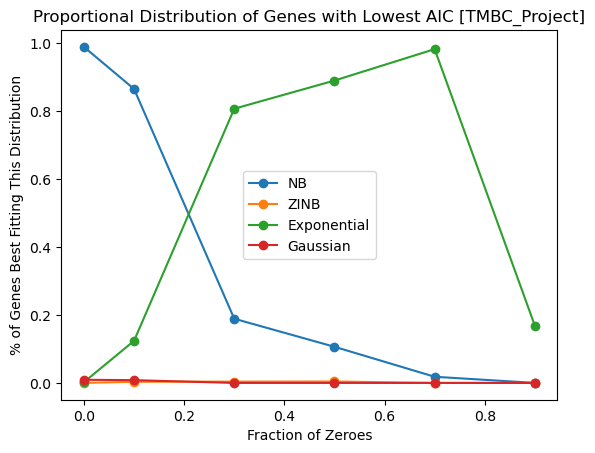

In [ ]:
# the GDC Count-Me-In Data
data = pd.read_csv('/path/to/third_party/CountMeIn_BConly_third_party_ffpe/MBC_CMI_Compiled_Counts.tsv',
                  delimiter=' ') # space delimited

tumours_counts = pd.DataFrame(data)
tumours_counts = tumours_counts.drop(tumours_counts.columns[:3], axis=1) # columns 1-3 should be ignored

tumours_counts_libadjust = library_adjust(tumours_counts)
fraction_of_zeroes = (tumours_counts_libadjust == 0).mean(axis=1)
filtered_df = tumours_counts_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

print("TMBC_Project")
tum_data = segmental_aic_find(filtered_df)
gradual_aic_plot(tum_data, "TMBC_Project") 



In [ ]:
# Our dataset!
all_counts = pyreadr.read_r('/path/to/our_dcis/expression_counts.Jan2023_1_2_and_2_2.rds')
vst_norm = pyreadr.read_r('/path/to/our_dcis/expression_VST_Normalized.Jan2023_1_2_and_2_2.rds')

# this data is loading without issue
ship_data = pyreadr.read_r('/path/to/our_dcis/ship1_2_full_tbl.Jan2023.With_Stroma_Assignment.rds')
# I wish that we could've simply used the RDA, but the counts-only RDS works and loads faster so what can you do
# in the future, could try the package 'rpy2' instead, it's an alternative that requires R but that's okay for us

# now we want to isolate just the expression from a particular type of tissue
df = all_counts[None] # load all_counts into a pandas data frame

# Eliminate any samples in the blacklist
ship_df = ship_data[None]
#print(ship_df['blacklist'].value_counts()) # they're all false

# since ship_data already has patients filtered out, lets filter out any patient who isn't on the list
# match by 'sample_name'
df_blacklist_filtered = df[ship_df['sample_name']]

# split the patients by tissue
count_DCIS = df_blacklist_filtered.filter(like='_D')
count_STROMA = df_blacklist_filtered.filter(like='_S')
count_NORMAL = df_blacklist_filtered.filter(like='_N')

vst_table = vst_norm[None] # we don't apply this anymore because it blocks any gene with >80% frac_zero
filtered_norm_count = count_NORMAL#[count_NORMAL.index.isin(vst_table.index)]
filtered_tumour_count = count_DCIS#[count_DCIS.index.isin(vst_table.index)]
filtered_stroma_count = count_STROMA#[count_STROMA.index.isin(vst_table.index)]

filtered_norm_count_libadjust = library_adjust(filtered_norm_count)
fraction_of_zeroes = (filtered_norm_count_libadjust == 0).mean(axis=1)
filtered_norm_count = filtered_norm_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

filtered_tumour_count_libadjust = library_adjust(filtered_tumour_count)
fraction_of_zeroes = (filtered_tumour_count_libadjust == 0).mean(axis=1)
filtered_tumour_count = filtered_tumour_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

filtered_stroma_count_libadjust = library_adjust(filtered_stroma_count)
fraction_of_zeroes = (filtered_stroma_count_libadjust == 0).mean(axis=1)
filtered_stroma_count = filtered_stroma_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients


Our Data: Tumours


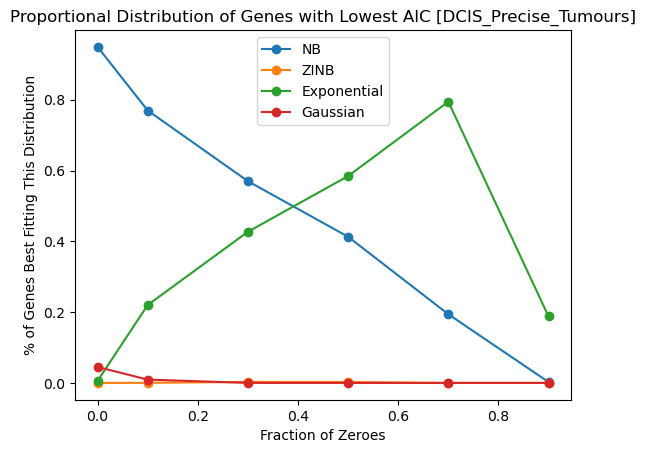

In [19]:
print("Our Data: Tumours")
tum_data = segmental_aic_find(count_DCIS)
gradual_aic_plot(tum_data, "DCIS_Precise_Tumours") 


Our Data: Normal


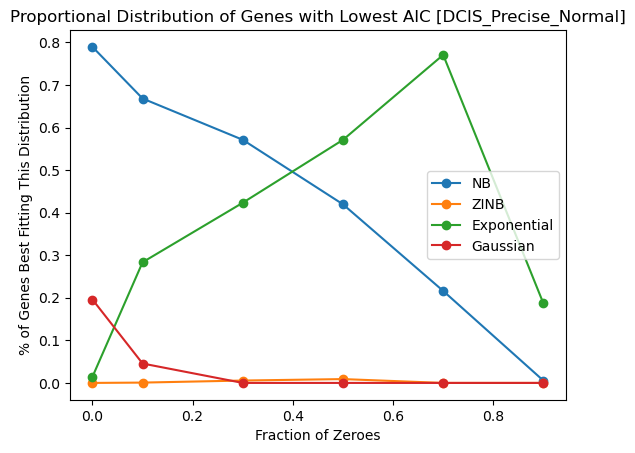

In [20]:
print("Our Data: Normal")
tum_data = segmental_aic_find(count_NORMAL)
gradual_aic_plot(tum_data, "DCIS_Precise_Normal") 

Our Data: Stroma


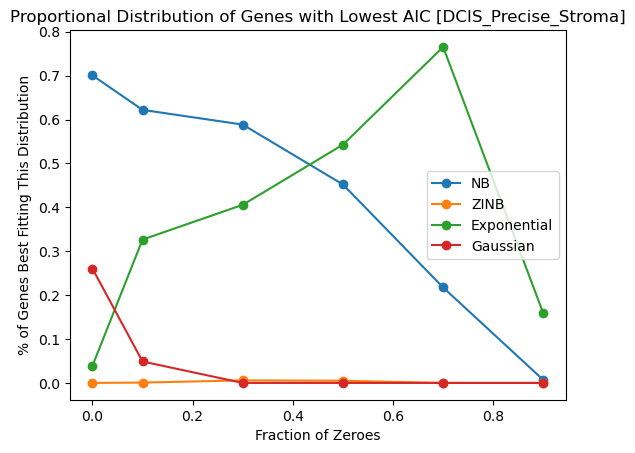

In [21]:
print("Our Data: Stroma")
tum_data = segmental_aic_find(count_STROMA)
gradual_aic_plot(tum_data, "DCIS_Precise_Stroma") 